In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [86]:
data = pd.read_csv("preprocessed-data/krwvnd.csv")
data.rename(columns={'Date': 'ds', 'Close':'y'}, inplace=True)
data["ds"] = pd.to_datetime(data["ds"])
data

,ds,y
0,2004-01-02,12.661377
1,2004-01-05,12.597076
2,2004-01-06,12.724485
3,2004-01-07,12.622449
4,2004-01-08,12.665998
...,...,...
5974,2023-10-27,18.123903
5975,2023-10-28,18.123247
5976,2023-10-29,18.123247
5977,2023-10-30,18.211071


In [87]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(len(train), len(test))

4783 1196


In [76]:
def create_dataset(dataset, look_back=1):
    data_prof = dataset.copy()
    for i in range(look_back, 0, -1):
        data_prof[f'y-{i}'] = dataset['y'].shift(i)
    data_prof = data_prof.dropna()
    return data_prof


In [82]:
look_back = 1
train_pf = create_dataset(train, look_back)
test_pf = create_dataset(test, look_back)

In [89]:
param_grid = {
    'seasonality_mode': ['additive'], #['additive', 'multiplicative']
    'changepoint_prior_scale': [0.01], #[0.01, 0.1, 0.5]
    'seasonality_prior_scale': [1], #[1, 10, 30]
}


In [90]:
best_params = {}
best_score = float('inf')

In [91]:
for mode in param_grid['seasonality_mode']:
    for cps in param_grid['changepoint_prior_scale']:
        for sps in param_grid['seasonality_prior_scale']:
            # Create a model with the current hyperparameters
            model = Prophet(seasonality_mode=mode, 
                            changepoint_prior_scale=cps, 
                            seasonality_prior_scale=sps, 
                            yearly_seasonality=True, 
                            weekly_seasonality=True, 
                            daily_seasonality=False
                            )
            model.fit(data)

            # Evaluate the model using Mean Squared Error (MSE) and cross validation
            df_cv = cross_validation(model, initial='730 days', period='30 days', horizon='1 days')
            score = mean_squared_error(df_cv['y'], df_cv['yhat'])

            # Update best parameters
            if score < best_score:
                best_score = score
                best_params = {
                    'seasonality_mode': mode,
                    'changepoint_prior_scale': cps,
                    'seasonality_prior_scale': sps
                }

19:54:27 - cmdstanpy - INFO - Chain [1] start processing
19:54:28 - cmdstanpy - INFO - Chain [1] done processing
19:54:29 - cmdstanpy - INFO - Chain [1] start processing
19:54:29 - cmdstanpy - INFO - Chain [1] done processing
19:54:29 - cmdstanpy - INFO - Chain [1] start processing
19:54:29 - cmdstanpy - INFO - Chain [1] done processing
19:54:29 - cmdstanpy - INFO - Chain [1] start processing
19:54:29 - cmdstanpy - INFO - Chain [1] done processing
19:54:29 - cmdstanpy - INFO - Chain [1] start processing
19:54:29 - cmdstanpy - INFO - Chain [1] done processing
19:54:29 - cmdstanpy - INFO - Chain [1] start processing
19:54:29 - cmdstanpy - INFO - Chain [1] done processing
19:54:29 - cmdstanpy - INFO - Chain [1] start processing
19:54:30 - cmdstanpy - INFO - Chain [1] done processing
19:54:30 - cmdstanpy - INFO - Chain [1] start processing
19:54:30 - cmdstanpy - INFO - Chain [1] done processing
19:54:30 - cmdstanpy - INFO - Chain [1] start processing
19:54:30 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

In [93]:
best_model = Prophet(**best_params)
best_model.fit(train)

19:57:49 - cmdstanpy - INFO - Chain [1] start processing
19:57:50 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
future = best_model.make_future_dataframe(periods=train_size)
forecast = best_model.predict(future)


In [97]:
y_true = test['y'].values
y_pred = forecast['yhat'].values[-len(test):]

In [100]:
mse = mean_squared_error(y_true, y_pred)
mse

24.396802157327

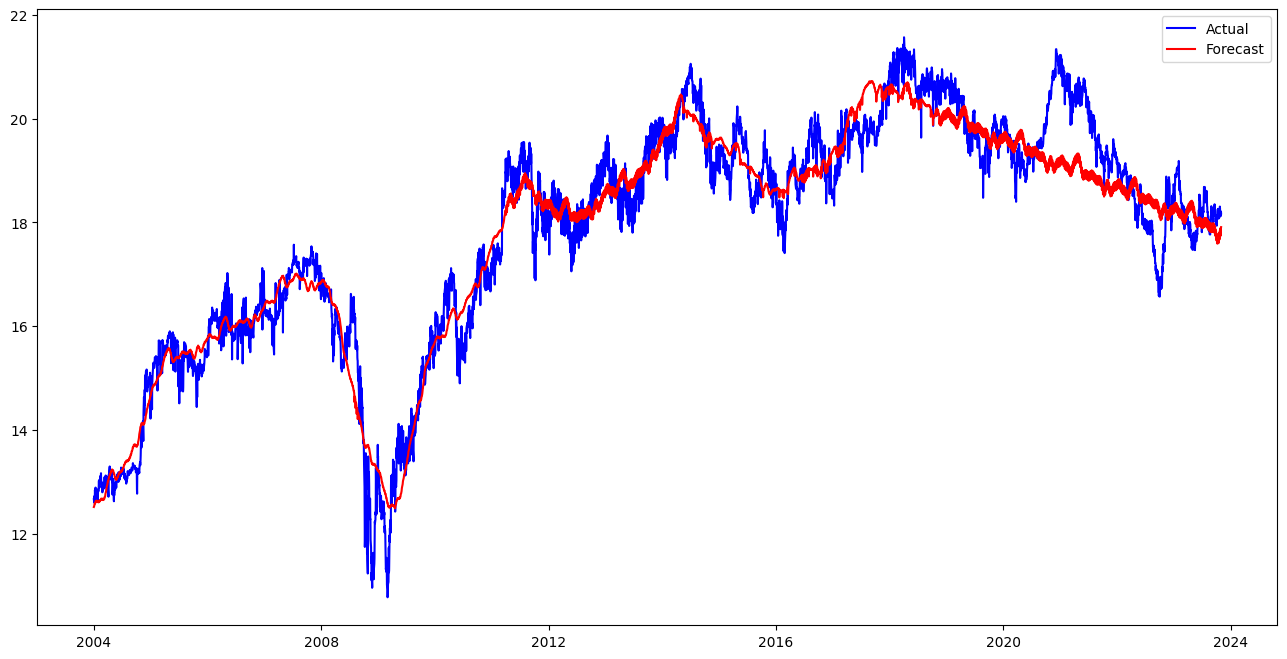

In [107]:
plt.figure(figsize=(16,8))
plt.plot(data['ds'], data['y'], label='Actual', color='blue')
plt.plot(forecast['ds'][:len(data)], forecast['yhat'][:len(data)], label='Forecast', color='red')
plt.legend()
plt.show()